# <center>Network Science</center>

Home Assignment #1: Network description and network centralities

In [72]:
import networkx as nx
import numpy as np
from collections import Counter
import pandas as pd
from ipywidgets import interact
# from ipywidgets import interact
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest, powerlaw, exponpow
from matplotlib.cm import cubehelix
%matplotlib inline

In [44]:
from matplotlib.pyplot import xkcd
ultraviolet = '#645394'
xkcd()
cmap = 'PRGn_r'

In [3]:
def eigenvector_centrality(G):
    return nx.eigenvector_centrality(G, max_iter=500)

In [4]:
def getTop(G, centrality, n=10):
    return {k:v for k, v in sorted(centrality(G).items(), key=lambda x:x[-1], reverse=True)[:n]}

In [48]:
def draw_(G, pos, metrics, rescale_metrics=True, norm_coef=100):
    def rescale_log(weigths_list):
        cutoff = 1e-20
        for _ in range(len(weigths_list)):
            if weigths_list[_] < cutoff:
                weigths_list[_] = cutoff
        return 1/(np.log(np.array(weigths_list)))
    
    
    if rescale_metrics:
        metrics = rescale_log(metrics) 
        
    norm = norm_coef/np.max(metrics)
    options_n = {
    'node_color': [v * norm for v in metrics],
    'node_size': [v * norm/2 for v in metrics],
    'cmap': cmap,
    'with_labels': False
    }
    options_e = {
    'line_color': 'grey',
    'linewidths': 0.5,
    'width': 0.5
    }
    nodes = nx.draw_networkx_nodes(G, pos, **options_n)
    nodes.set_edgecolor('grey')
    nx.draw_networkx_edges(G, pos, **options_e)

In [49]:
def show_graph(G, metrics, root, rescale_log=False, scheme='neato', norm_coef=100):
    fig = plt.figure(clear=True)
    fig.set_size_inches(20.5, 12.5, forward=True)
    pos = nx.nx_pydot.graphviz_layout(G, prog=scheme, root=root)
    plt.grid(False)
    plt.axis(False)
    draw_(G, pos, metrics, rescale_log, norm_coef=norm_coef)

In [7]:
schemes = ['neato', 'dot', 'twopi', 'fdp', 'sfdp', 'circo']

#### <hr /> General Information

**Due Date:** 08.05.2020 18:00 <br>
**Late submission policy:** -1 points per day <br>


Please send your reports to <iakarpov@hse.ru> with message subject of the following structure: <br>
**[HSE SNA Magolego 2020] *{LastName}* *{First Name}* HW_*{Number}***

Support your computations with figures and comments. <br>
If you are using IPython Notebook you may use this file as a starting point of your report.

## Problems

### Task 1. Data preparation

<img src ="https://dl.dropboxusercontent.com/s/nt1tbmathgo3gg8/g1.png?dl=1" style="width:600px;heigth:200px">

1.1. Load [VKontakte](https://dl.dropboxusercontent.com/s/8eo1sjfhu5spb0f/vk.tsv?dl=1) dataset to NetworkX + <br>
1.2. Choose 3-5 nodes from the existing network and create the subgraph with network framing (only `seed` and `friends#1` nodes, only `r0`, `r1`, `r2` edges) <br>
1.3. Find graph diameter, average and global clustering coefficient <br>
1.4. Find max and mean values of incoming and outcoming node degrees <br>
1.5. Vizualize your graph in gephi or networkX or grahistry <br>


In [8]:
vkdata = pd.read_csv('./data/vk.tsv', sep='\t', index_col=0)
vkdata['Friends'] = vkdata['Friends'].apply(lambda x : x.replace('VK_', 'id'))
vkdata['ID'] = vkdata['ID'].apply(lambda x : x.replace('VK_', 'id'))
print(vkdata.shape[0])
vkdata.head()

125625


,Friends,ID,Name
0,id4766099,id97803804,Никита Кузнецов
1,id5227712,id97803804,Никита Кузнецов
2,id11047376,id97803804,Никита Кузнецов
3,id11079816,id97803804,Никита Кузнецов
4,id14492163,id97803804,Никита Кузнецов


In [9]:
dreamteam = ['Александра Корецкая', 'Мария Баханова', 'Даша Ким', 'Илья Селиванов']

fcount = vkdata.groupby('Name').count()['Friends'].to_frame().sort_values(by='Friends', ascending=False)
fcount.loc[dreamteam]

In [11]:
G = nx.from_pandas_edgelist(vkdata, source='ID', target='Friends')

In [12]:
seed = set(vkdata[vkdata.Name.isin(dreamteam)].ID.unique())

In [13]:
seed_and_friends = list(set(vkdata[(vkdata.ID.isin(seed)) | (vkdata.Friends.isin(seed))].Friends.unique()) | seed)

In [14]:
metrics = list(map(lambda x : float(x in seed), G.subgraph(seed_and_friends).nodes()))
Gsub = G.subgraph(seed_and_friends)

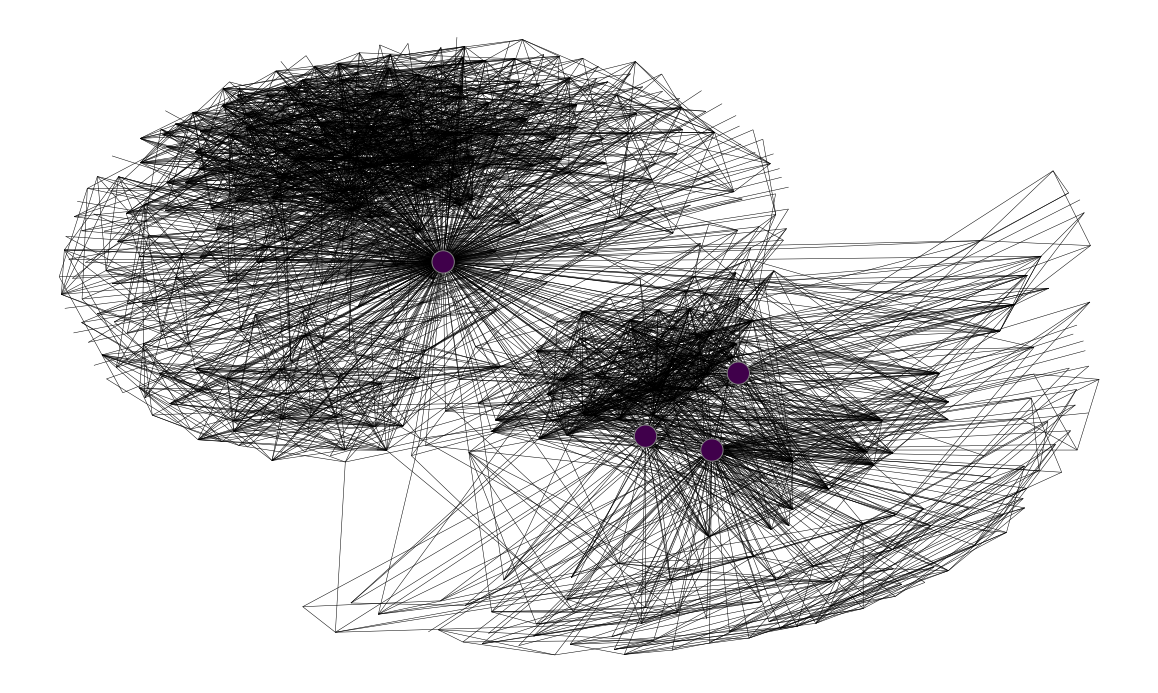

In [50]:
show_graph(Gsub, metrics, seed_and_friends[0], norm_coef=1000)

In [16]:
print('Number of connected components:', nx.number_connected_components(Gsub))

Number of connected components: 1


Friendship graph is undirected, therefore incoming and outcoming node degrees are equal.

In [17]:
max_degree = max([d for n, d in Gsub.degree()])
avg_degree = round(sum([d for n, d in Gsub.degree()]) / Gsub.number_of_nodes(), 3)
print('Max degree: {}'.format(max_degree))
print('Average degree: {}'.format(avg_degree))

Max degree: 360
Average degree: 14.126


In [18]:
# Find graph diameter, average and global clustering coefficient

diameter = nx.diameter(Gsub)
avgclust = round(nx.average_clustering(Gsub), 3)
globclust = round(nx.transitivity(Gsub), 3)

In [19]:
print('Diameter: {}\nAverage clustering coefficient: {}\nGlobal clustering coefficient (transitivity): {}'.format(diameter,
                                                                                                                  avgclust, 
                                                                                                                  globclust)
     )

Diameter: 3
Average clustering coefficient: 0.612
Global clustering coefficient (transitivity): 0.252


### Task 2. Power Law
2.1. Check that Zipf's Law holds <br>
2.2. Assuming that the data is distributed according to the Power Law, find :
 * $\alpha$ of the distribution
 * mean sample variance $\sigma^2$
 
2.3. Determine $x_{min}$ via Kolmogorov-Smirnov test

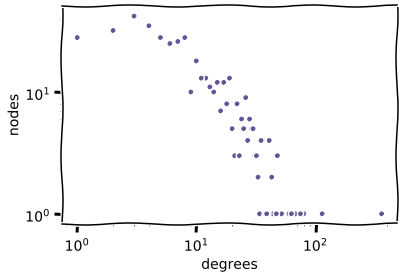

In [51]:
d = Counter([d for n, d in Gsub.degree()])
plt.xlabel('degrees')
plt.ylabel('nodes')
plt.loglog(list(d.keys()), list(d.values()), '.', lw=2, color=ultraviolet)
plt.show()

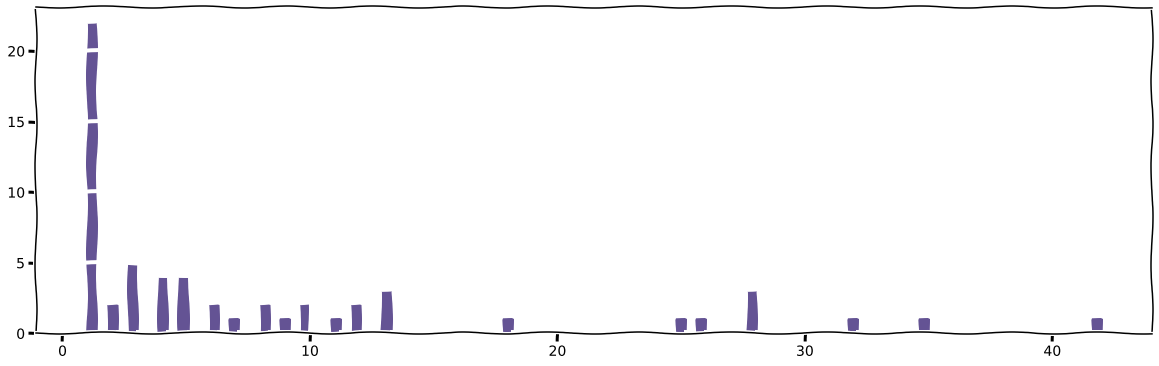

In [53]:
degrees = np.array(list([d for n, d in Gsub.degree()]))
degree_freq = pd.Series(degrees).value_counts()

plt.figure(figsize=(20, 6))
degree_freq.hist(bins=100, color=ultraviolet)
plt.show()

$$\alpha = 1 + n\left[ \sum \ln \frac{x_i}{x_\min} \right]^{-1}$$

$$\sigma = \frac{\alpha - 1}{\sqrt n }$$

In [92]:
def alpha(X: np.array, x_min=0) -> float:
    X = X[X>=x_min]
    n = len(X)
    alpha_ = 1 + n/np.sum(np.log(X/X.min()))
    return alpha_

In [93]:
def sigma(X: np.array, x_min=0) -> float:
    n = len(X[X>=x_min])
    sigma_ = (alpha(X, x_min)-1)/np.sqrt(n)
    return sigma_

In [94]:
def f_exp(x, x_min):
    result = 0.0
    N = 0.0
    for degree, nodes in d_dict.items():
        if degree >= x_min:
            N += nodes
            if degree <= x:
                result += nodes
    return result / N


def f_model(x, x_min, alpha):
    return 1 - (x / x_min) ** (1 - alpha)

In [104]:
def calculate_D(X, x_min):
    D_cords = {}
    array = []
    alpha_ = alpha(X, x_min)
    for degree in d_dict.keys():
        if degree >= x_min:
            result = np.abs(f_model(degree, x_min, alpha_) - f_exp(degree, x_min))
            array.append(result)
            D_cords[x_min] = result
    return max(array)

In [105]:
x_min_map = {}
for degree in set(degrees):
    d_dict = Counter(degrees)
    x_min_map[degree] = calculate_D(degrees, degree + 0.0)

/home/kim/juche/pet-projects/networksch/networks/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


$$x^*_{min} = argmin_{x_{min}}D$$

In [107]:
real_x_min = min(x_min_map, key=x_min_map.get) + 0.0
print(real_x_min)

real_alpha = alpha(degrees, real_x_min)
real_C = (real_alpha - 1) * (real_x_min ** (real_alpha - 1))

23.0


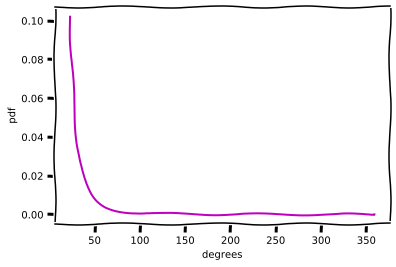

In [117]:
def pdf(x):
    return real_C * x ** (-real_alpha)

x = np.arange(real_x_min, max(degrees), 1)

plt.xlabel('degrees')
plt.ylabel('pdf')
plt.plot(x, pdf(x), 'm', label = 'PDF')
plt.show()

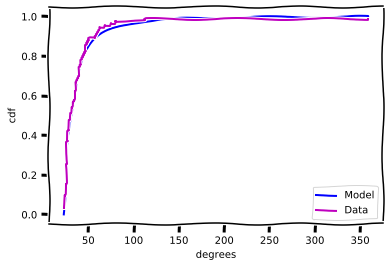

In [118]:
def cdf(x):
    return 1 - (x / real_x_min) ** (1 - real_alpha)

model, = plt.plot(x, cdf(x), 'b', label = 'Model')
y = []
for point in x:
    y.append(f_exp(point, real_x_min))
data,  = plt.step(x, y, 'm', label = 'Data')
plt.xlabel('degrees')
plt.ylabel('cdf')
plt.legend(handles = [model, data])
plt.show()

In [114]:
def ccd(x, n_bins):
    ticks = np.linspace(min(x), max(x), num=n_bins)
    hist = []
    for t in ticks:
        hist.append(sum([_>=t for _ in x]))
    return np.array(hist), np.array(ticks)

def plotCCDist(X, n_bins=200, title='Degree distribution CCD', axis=None, l=50):
    n_bins = 200
    dens, bin_edges = ccd(X, n_bins)
    bins = bin_edges/2

    nonzero_bins = bins[np.nonzero(bins)]
    nonzero_dens = dens[np.nonzero(dens)]
    linear_appr = np.polyfit(np.log(nonzero_bins)[:-l], np.log(nonzero_dens)[:-l], 1)
    print(linear_appr)
    
    plt.loglog(nonzero_bins, nonzero_dens, '--o')
    plt.loglog(nonzero_bins, nonzero_bins**linear_appr[0] * np.exp(linear_appr[1]), '--', color='r')
    
    plt.title(title)
    plt.xlabel(r'$ k$', fontsize=14)
    plt.ylabel(r'$\rho(k)$', fontsize=14)
    plt.show()

In [115]:
@interact
def show_plot(k=(0, 20, 1)):
    plotCCDist(degrees[degrees>k])

interactive(children=(IntSlider(value=10, description='k', max=20), Output()), _dom_classes=('widget-interact'…

[-1.70795406  7.77067262]


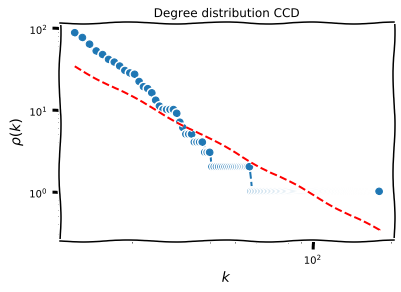

In [116]:
plotCCDist(degrees[degrees>23])

In [119]:
alpha(degrees, real_x_min)

3.345723124672811

In [120]:
sigma(degrees, real_x_min)**2

0.06113796641805308

### Task 3. Structural analysis

3.1. Print 5 nodes with maximum degree centrality, vizualize your graph with color or size as the function of degree <br>
3.2. Print 5 nodes with maximum betweenness centrality, vizualize your graph with color or size as the function of degree <br>
3.3. Print 5 nodes with maximum eigenvector centrality, vizualize your graph with color or size as the function of degree <br>
3.4 Print histogram with centralities distribution of your graph <br>

In [89]:
# Print 5 nodes with maximum degree centrality, vizualize your graph with color or size as the function of degree
top5_degree = getTop(Gsub, nx.degree_centrality, 5)
top5_betweenness = getTop(Gsub, nx.betweenness_centrality, 5)
top5_eigenvector = getTop(Gsub, eigenvector_centrality, 5)

In [101]:
# Print 5 nodes with maximum degree centrality, vizualize your graph with color or size as the function of degree
degree = [c for n, c in nx.degree_centrality(Gsub).items()]
betweenness = [c for n, c in nx.betweenness_centrality(Gsub).items()]
eigenvector = [c for n, c in eigenvector_centrality(Gsub).items()]

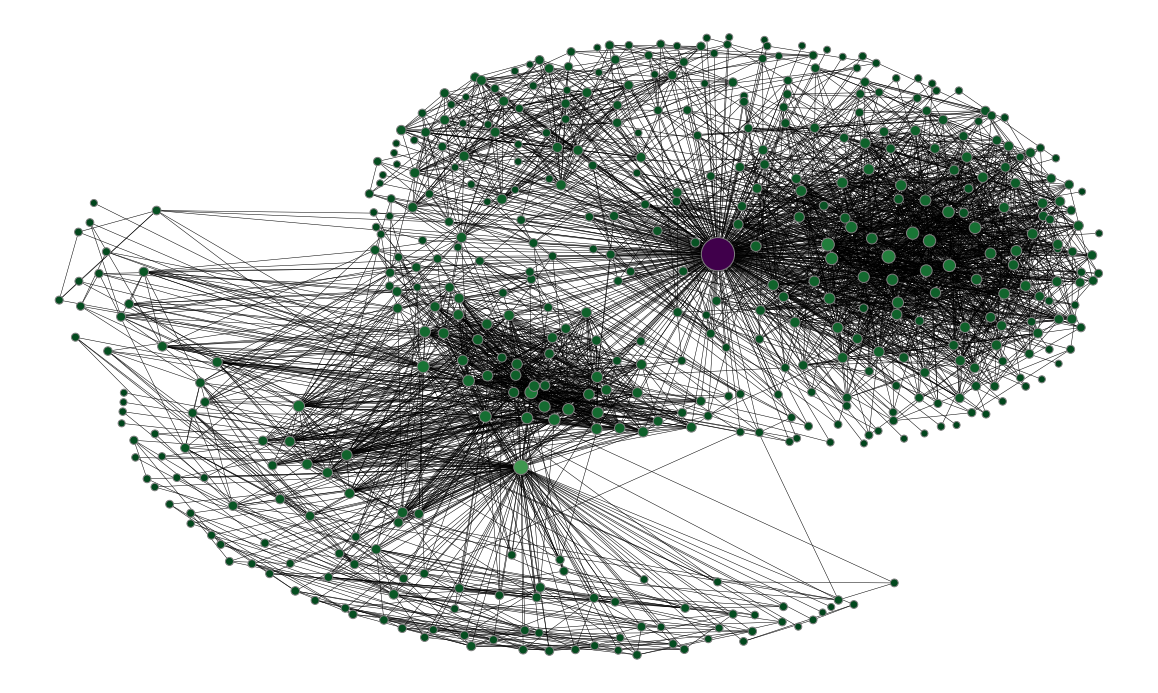

In [109]:
show_graph(Gsub, degree, seed_and_friends[0], rescale_log=True)

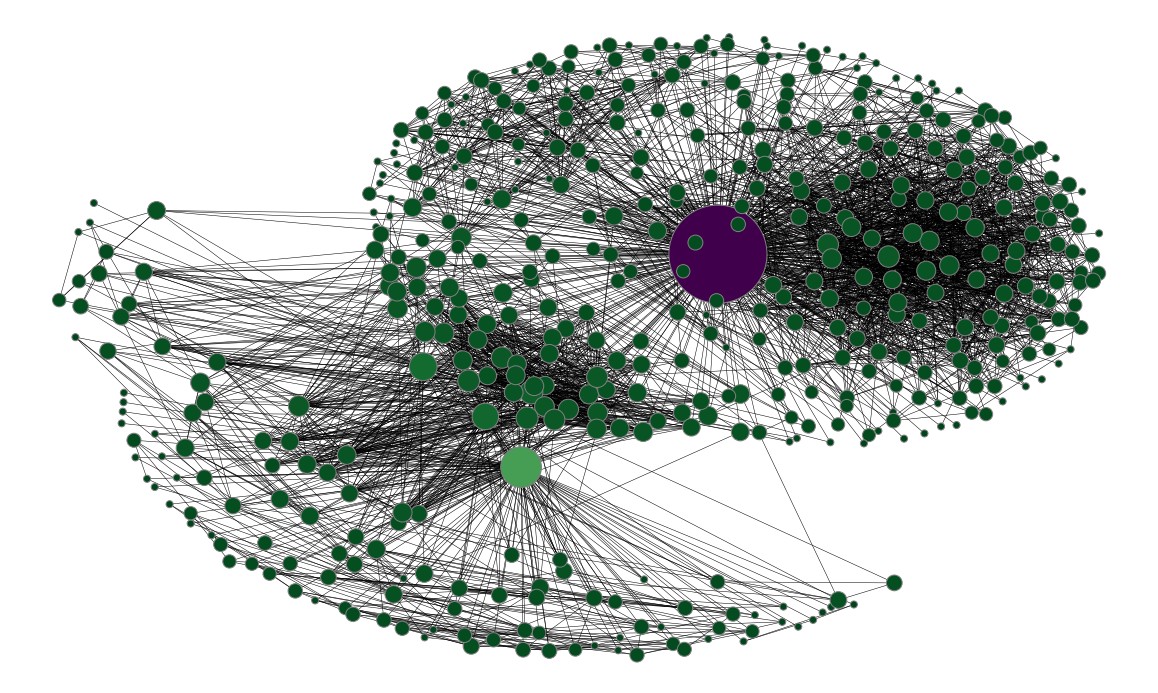

In [110]:
show_graph(Gsub, betweenness, seed_and_friends[0], rescale_log=True)

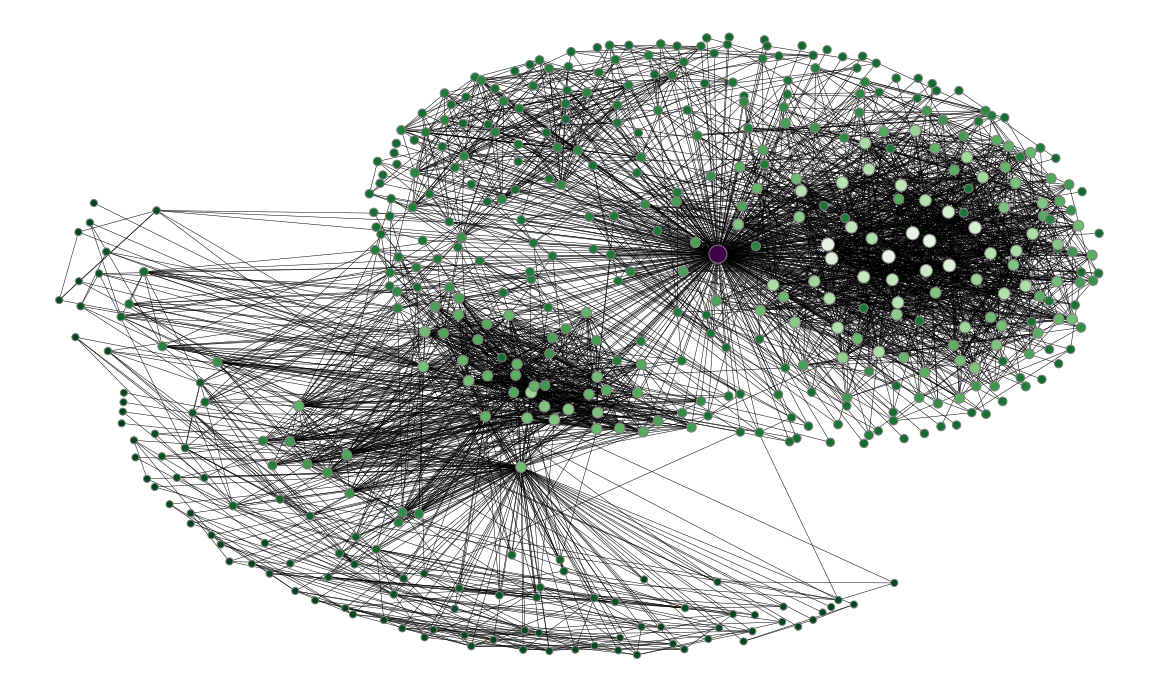

In [111]:
show_graph(Gsub, eigenvector, seed_and_friends[0], rescale_log=True)

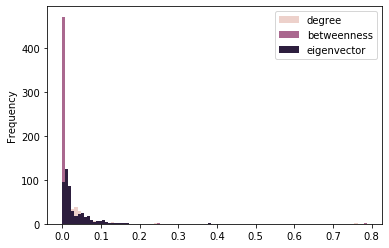

In [146]:
cmap = colormap=ListedColormap(sns.cubehelix_palette(n_colors=3))
centralities_df = pd.DataFrame(np.array([degree, betweenness, eigenvector]).T, 
                               columns=['degree', 'betweenness', 'eigenvector'], index=list(Gsub.nodes()))
centralities_df.plot.hist(bins=100, colormap=cmap)
plt.show()